In [1]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('./libs')

import os
os.environ["PROJ_LIB"] = r"~/anaconda3/Library/share"; #fixr

import matplotlib.pyplot as plt
import random
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from datetime import date

from netCDF4 import Dataset, MFDataset
import pandas as pd

%matplotlib inline

In [2]:
def get_rand_color():
    cor = [random.randrange(0, 90)/100, random.randrange(0, 60)/100, random.randrange(0, 90)/100]
    return cor

## Trackings Visualization

In [3]:
EXP= r'./'


# WEDDELL
lat_s = -78
lat_n = -60
lon_w = -65
lon_e = -20

# ROSS
#lat_s = -79
#lat_n = -65
#lon_w = -190
#lon_e = -147

bounds_map = [lat_s, lat_n, lon_w, lon_e]

In [4]:
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = list(zip(x, y))
    poly = Polygon(xy, color='r', alpha = 0.8)
    plt.gca().add_patch(poly)

In [5]:
def set_mini_map(m, x, bounds_map):
    
    #min_lat, max_lat = min(m.boundarylats), max(m.boundarylats)
    #min_lon, max_lon = min(m.boundarylons)+25, max(m.boundarylons)
    min_lat, max_lat = bounds_map[0], bounds_map[1]
    min_lon, max_lon = bounds_map[2], bounds_map[3]+10.
    
    # Global map inset
    m.ax = ax
    axin = inset_axes(m.ax, width="20%", height="20%", loc=1)
    inmap = Basemap(projection='spstere', boundinglat=-62, lat_0=-90, lat_ts=-71, lon_0=-180, resolution='l', ax=axin, anchor='NE')
    
    inmap.drawcoastlines()
    inmap.fillcontinents(color='peachpuff')

    lats = [max_lat, min_lat, min_lat, max_lat]
    lons = [min_lon, min_lon, max_lon, max_lon]

    draw_screen_poly(lats, lons, inmap)

In [6]:
def polar_stere(lon_w, lon_e, lat_s, lat_n, **kwargs):
    '''Returns a Basemap object (NPS/SPS) focused in a region.
    lon_w, lon_e, lat_s, lat_n -- Graphic limits in geographical coordinates.
                                  W and S directions are negative.
    **kwargs -- Aditional arguments for Basemap object.
    '''

    # lat_0=-75, lat_ts=-71, lon_0=-45,

    lon_0 = lon_w + (lon_e - lon_w) / 2.
    ref = lat_s if abs(lat_s) > abs(lat_n) else lat_n
    lat_0 = np.copysign(90., ref)
    proj = 'npstere' if lat_0 > 0 else 'spstere'
    prj = Basemap(projection=proj, lon_0=lon_0, lat_0=lat_0,
                          boundinglat=0, resolution='c')
    lons = [lon_w, lon_e, lon_w, lon_e, lon_0, lon_0]
    lats = [lat_s, lat_s, lat_n, lat_n, lat_s, lat_n]
    x, y = prj(lons, lats)
    ll_lon, ll_lat = prj(min(x), min(y), inverse=True)
    ur_lon, ur_lat = prj(max(x), max(y), inverse=True)
    return Basemap(projection='stere', lat_0=lat_0, lon_0=lon_0,
                           llcrnrlon=ll_lon, llcrnrlat=ll_lat,
                           urcrnrlon=ur_lon, urcrnrlat=ur_lat, **kwargs)

In [7]:
def get_base_map(lat_s, lat_n, lon_w, lon_e):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    m = polar_stere(lon_w, lon_e, lat_s, lat_n)
    m.drawmapboundary(fill_color='white')

    path_shp = './LandMask/antarticamask'
    m.readshapefile(path_shp, 'antarticamask')

    patches = []
    for info, shape in zip(m.antarticamask_info, m.antarticamask):
        patches.append(Polygon(np.array(shape), True))

    ax.add_collection(PatchCollection(patches, facecolor='peachpuff', edgecolor='k', linewidths=1., zorder=2))
    
    path_shp = './LandMask/shelves/ne_10m_antarctic_ice_shelves_polys'
    m.readshapefile(path_shp, 'ne_10m_antarctic_ice_shelves_polys')

    patches = []
    for info, shape in zip(m.ne_10m_antarctic_ice_shelves_polys_info, m.ne_10m_antarctic_ice_shelves_polys):
        patches.append(Polygon(np.array(shape), True))

    ax.add_collection(PatchCollection(patches, facecolor='lightskyblue', edgecolor='k', linewidths=1., zorder=2))
    

    m.drawparallels(np.arange(-90., 90, 3), labels=[1, 1, 0, 0], linewidth=0.2, rotation=45)
    m.drawmeridians(np.arange(-180., 180., 10), labels=[0, 0, 0, 1], linewidth=0.2, rotation=45)
    
    plt.xlabel('Longitude', labelpad=40, fontsize=16)
    plt.ylabel('Latitude', labelpad=40, fontsize=16)
        
    return m, ax

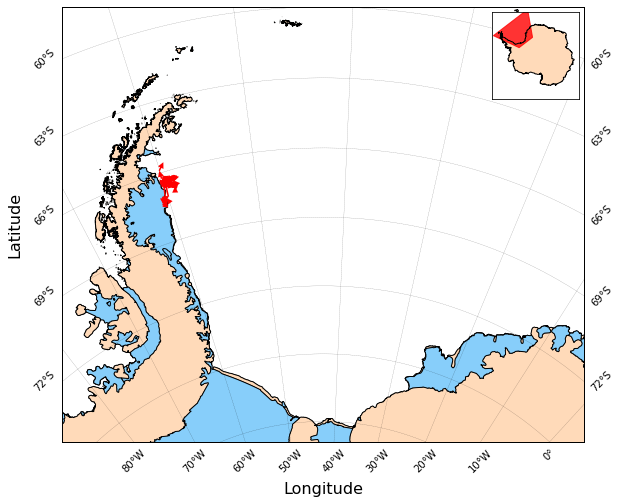

In [10]:
#berg = pd.read_csv(EXP+r'saidas/Weddell/full_all_with_pp3/track_145_12524.txt', sep=' ')
berg = pd.read_csv(EXP+r'saidas/Weddell//temp/btest.txt', sep=' ')

m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)

#x, y = m(berg['longitude'].values, berg['latitude'].values)
#m.plot(x, y,linewidth=2, color='red', markerfacecolor='red')

for i in range (0,  len(berg['longitude'])):
    
    if i > 0:
        x_ant, y_ant = x, y
        x, y = m(berg.loc[i, 'longitude'], berg.loc[i, 'latitude'])
        
    else:
        x, y = m(berg.loc[i, 'longitude'], berg.loc[i, 'latitude'])

    if i > 0:
        plt.annotate('', xy=(x, y), xycoords='data', xytext=(x_ant, y_ant),textcoords='data', size=0.5, 
                    arrowprops=dict(headwidth=6, headlength=6, width=1.5, facecolor='r',  edgecolor="none", 
                                    connectionstyle="arc3, rad=0.001"))

set_mini_map(m, ax, bounds_map)

# plt.savefig(EXP+'0 - imagens DEMO/'+'A1_Individual_example.jpg', dpi = 600)

## PLOTA NUVEM DE PONTOS

In [ ]:
#%matplotlib qt

path_files = EXP+r'saidas/Weddell/full_all_with_pp3/'

m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)

cont=0
for file_bergs in sorted(os.listdir(path_files)):   

    if file_bergs.startswith("track_"):

        berg = pd.read_csv(path_files+file_bergs, sep=' ')
        if int(berg.loc[0, 'date'][0:4]) >= 2000:
        #if float(berg.loc[0, 'longitude']) > -65 :
        # if len(berg['area_km2']) >= 0 :
        # if int(berg.loc[0, 'area_km2']) <= 1. :
            
            cont+=1
                
            x, y = m(berg['longitude'].values, berg['latitude'].values)
            m.plot(x, y,'ro', ms="2.0", color=get_rand_color())

set_mini_map(m, ax, bounds_map)

print('Total of individual drifting-icebergs: ', cont) 

# plt.savefig(EXP+'0 - imagens DEMO/'+'A1_all_cloud.jpg', dpi = 600)

## PLOTA INITIAL POINT

In [ ]:
#%matplotlib qt

path_files = EXP+r'saidas/Weddell/full_all_with_pp3/'

m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)

a1 = 0
a2 = 0
a3 = 0
a4 = 0
a5 = 0

cont=0
for file_bergs in sorted(os.listdir(path_files)):   

    if file_bergs.startswith("track_"):

        berg = pd.read_csv(path_files+file_bergs, sep=' ')
        if int(berg.loc[0, 'date'][0:4]) >= 2000:
        #if float(berg.loc[0, 'longitude']) > -65 :
        # if len(berg['area_km2']) >= 0 :
        # if int(berg.loc[0, 'area_km2']) <= 1. :
            
            if berg.loc[0,'area_km2'] < 1:
                a1 += 1
            if 1 < berg.loc[0,'area_km2'] < 10:
                a2 += 1
            if 10 < berg.loc[0,'area_km2'] < 100:
                a3 += 1
            if 100 < berg.loc[0,'area_km2'] < 1000:
                a4 += 1
            if berg.loc[0,'area_km2'] > 1000:
                a5 += 1
            
            cont+=1
                
            x, y = m(berg.loc[0,'longitude'], berg.loc[0,'latitude'])
            m.plot(x, y,'ro', ms="2.0", color=get_rand_color())

set_mini_map(m, ax, bounds_map)

print('Total of individual drifting-icebergs: ', cont) 
print(a1,a2,a3,a4,a5)

# plt.savefig(EXP+'0 - imagens DEMO/'+'A1_all_cloud.jpg', dpi = 600)

## PLOTA TODOS (FORMATO ESPAGUETE)

track_145_12524.txt
track_145_145.txt
track_145_53442.txt
track_147_5693.txt
track_176.txt
track_2955_37219.txt
track_2955_37314.txt
Total of individual drifting-icebergs:  7


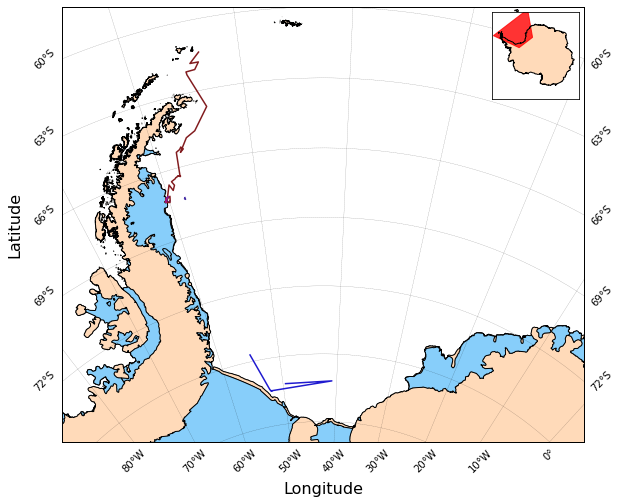

In [54]:
#%matplotlib qt

path_files = EXP+r'saidas/Weddell/full_all_with_pp3/'
#path_files = EXP+r'saidas/weddell/saidas/'

m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)

cont=0
for file_bergs in sorted(os.listdir(path_files)):   

    if file_bergs.startswith("track"):
    #if file_bergs.startswith("ICE_"):

        berg = pd.read_csv(path_files+file_bergs, sep=' ')
        #if int(berg.loc[0, 'date'][0:4]) != 2000:
        # if len(berg['area_km2']) >= 10 and berg.loc[0, 'latitude'] < -74 and berg.loc[0, 'longitude'] > -45:
        if 1200 < int(berg.loc[0, 'area_km2']) < 1300 :
        # if float(berg.loc[0, 'longitude']) > -65 :
            
            print(file_bergs)
            cont+=1
                
            x, y = m(berg['longitude'].values, berg['latitude'].values)
            #m.plot(x, y, color=np.random.choice(cores_names), lw=1.0, alpha=0.7)
            m.plot(x, y, color=get_rand_color())

set_mini_map(m, ax, bounds_map)

print('Total of individual drifting-icebergs: ', cont)
# plt.savefig(EXP+'0 - imagens DEMO/'+'A1_all.jpg', dpi = 600)

## PLOTA TODOS (COM DIRECAO)

In [ ]:
#%matplotlib qt
%matplotlib inline

m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)

path_files = EXP+r'saidas/Weddell/full_all/'
#path_files = EXP+r'saidas/Ross/full_all/'

n_bergs = 0
for file_bergs in sorted(os.listdir(path_files)):   

    if file_bergs.startswith("track_"):
    #if file_bergs.startswith("ICE_"):

        berg = pd.read_csv(path_files+file_bergs, sep=' ')
        
        if len(berg['date']) >= 0:
        #if float(berg.loc[0, 'longitude']) > -65 :
            
            cor_b = get_rand_color()
            n_bergs += 1
            
            for i in range (0,  len(berg['longitude'])):

                if i > 0:
                    x_ant, y_ant = x, y
                    x, y = m(berg.loc[i, 'longitude'], berg.loc[i, 'latitude'])

                else:
                    x, y = m(berg.loc[i, 'longitude'], berg.loc[i, 'latitude'])

                if i > 0:
                    plt.annotate('', xy=(x, y), xycoords='data', xytext=(x_ant, y_ant),textcoords='data', size=0.5, 
                                arrowprops=dict(headwidth=6, headlength=6, width=1.5, facecolor=cor_b, edgecolor="none", 
                                                alpha=0.7, connectionstyle="arc3, rad=0.001"))

set_mini_map(m, ax, bounds_map)

print('Total of individual drifting-icebergs: ', n_bergs)
#plt.savefig(EXP+r'saidas/Weddell/all_Direction.jpg', dpi = 300)

## Blank map

In [ ]:
m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)

plt.savefig(EXP+r'saidas/Weddell/weddell_base.jpg', dpi = 300)